# Train the StarNet Model

This notebook takes you through the steps of how to train a StarNet Model
- Required Python packages: `numpy h5py keras`
- Required data files: training_data.h5, mean_and_std.npy

Note: We use tensorflow for the keras backend.

In [1]:
import numpy as np
import h5py
import random
import keras
from keras.models import Model
from keras.layers import Input, Dense, InputLayer, Flatten, Reshape, Concatenate, concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import HDF5Matrix
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc





Using TensorFlow backend.


In [5]:
#RPFlux
pathbp = '/Users/aishasultan/work/synple-gaia/run/CNN/age_parameter/BP/spectra/spectra_feh_pos00+pos.25+neg.25.h5'
readbp = h5py.File(pathbp, 'r')
print(readbp.keys())
bpflux = readbp.get('bpflux')
bpflux = np.array(bpflux)
print('shape of bpflux:', np.shape(bpflux))


norm_bpflux= []
for ii in range(np.shape(bpflux)[0]):
        max_flux= np.max(bpflux[ii])
        normflux = bpflux[ii]/ max_flux
        #plt.plot(np.arange(40), normflux)
        #print('normflux:',normflux)
        norm_bpflux.append(normflux)

        
norm_bpflux= np.array(norm_bpflux)

print('shape of norm_bpflux:', np.shape(norm_bpflux))
#rint('output of norm_flux:', print(norm_rpflux[0:10]))







<KeysViewHDF5 ['bpflux']>
shape of bpflux: (300, 33)
shape of norm_bpflux: (300, 33)


In [6]:
mist0 = '/Users/aishasultan/work/MIST/feh_pos0.00_100randstr_EEP0.h5'
mist1 = '/Users/aishasultan/work/MIST/feh_pos.25_100randstr_EEP0.h5'
mist2 = '/Users/aishasultan/work/MIST/feh_neg.25_100randstr_EEP0.h5'



readmist0 = h5py.File(mist0, 'r')
readmist1 = h5py.File(mist1, 'r')
readmist2 = h5py.File(mist2, 'r')


#reading MIST0 file
print(readmist0.keys())
mist_logteff0 = readmist0.get('logteff_sel')
teff_sel0 = np.array(mist_logteff0)
mist_logg0 = readmist0.get ('logg_sel')
logg_sel0 = np.array(mist_logg0)
mist_feh0 = readmist0.get ('feh_sel')
feh_sel0 = np.array(mist_feh0)
mist_age0 = readmist0.get ('age_sel')
age_sel0 = np.array(mist_age0)


#reading MIST1 file
#print(readmist1.keys())
mist_logteff1 = readmist1.get('logteff_sel')
teff_sel1 = np.array(mist_logteff1)
mist_logg1 = readmist1.get ('logg_sel')
logg_sel1 = np.array(mist_logg1)
mist_feh1 = readmist1.get ('feh_sel')
feh_sel1 = np.array(mist_feh1)
mist_age1 = readmist1.get ('age_sel')
age_sel1 = np.array(mist_age1)

#reading MIST2 file
#print(readmist1.keys())
mist_logteff2 = readmist2.get('logteff_sel')
teff_sel2 = np.array(mist_logteff2)
mist_logg2 = readmist2.get ('logg_sel')
logg_sel2 = np.array(mist_logg2)
mist_feh2 = readmist2.get ('feh_sel')
feh_sel2 = np.array(mist_feh2)
mist_age2 = readmist2.get ('age_sel')
age_sel2 = np.array(mist_age2)


#MIST all parameters
logteff = np.hstack((teff_sel0, teff_sel1, teff_sel2))
logg = np.hstack ((logg_sel0, logg_sel1, logg_sel2))
feh = np.hstack ((feh_sel0, feh_sel1, feh_sel2))
age = np.hstack ((age_sel0, age_sel1, age_sel2))



print(age.max())
print(feh)

<KeysViewHDF5 ['age_sel', 'feh_sel', 'logg_sel', 'logteff_sel']>
10.3
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.

In [8]:

#features
num_tot = len(logteff)
print('total number of input stars =', num_tot)
plim = 0.8
ran_frac = np.random.uniform(0,1,num_tot)
#print('ranfrac=' , ran_frac)




#Input flux data of RVS, BP, RP
#x_RVStrain = norm_rvsflux[ran_frac < plim, :]
#print('number of RVS training data=', len(x_RVStrain[:,0]))
#x_RVScv = norm_rvsflux[ran_frac >= plim, :] #test set we left for the application

x_BPtrain = norm_bpflux[ran_frac < plim, :]
print('number of BP training data=', len(x_BPtrain[:,0]))
x_BPcv = norm_bpflux[ran_frac >= plim, :]

#x_RPtrain =norm_bpflux[ran_frac < plim, :]
#print('number of BP training data=', len(x_RPtrain[:,0]))
#x_RPcv = norm_bpflux[ran_frac >= plim, :]


#print('x_BPtrain', x_BPtrain)

#x_train_combined = np.vstack (x_RVStrain[0,:],x_RPtrain[0,:]) 

#output label which is the logteff, log g, feh, and age
y_logteff_train = logteff[ran_frac< plim]
y_logteff_cv = logteff[ran_frac >= plim] #test set

y_logg_train = logg[ran_frac< plim]
y_logg_cv = logg[ran_frac >= plim] #test set

y_feh_train = feh[ran_frac< plim]
y_feh_cv = feh[ran_frac >= plim] #test set

y_age_train = age[ran_frac< plim]
y_age_cv = age[ran_frac >= plim] #test set




print('The size of CVS for the input flux data')
#print('RVS cvs=', np.shape(x_RVScv))
print('BP cvs=', np.shape(x_BPcv))
#print('RP cvs=', np.shape(x_RPcv))

print('the size of output label=', np.shape(y_logteff_train) )

#id = np.linspace(0, len(x_RVStrain[:, 0])-1, len(x_RVStrain[:, 0]))
#plt.plot(id, y_logteff_train)
#plt.show()


total number of input stars = 300
number of BP training data= 238
The size of CVS for the input flux data
BP cvs= (62, 33)
the size of output label= (238,)


** Normalization **

Write a function to normalize the output labels. Each label will be normalized to have approximately have a mean of zero and unit variance.

NOTE: This is necessary to put output labels on a similar scale in order for the model to train properly, this process is reversed in the test stage to give the output labels their proper units

In [9]:
#mean_labels=np.mean(logteff)
#std_labels=np.std(logteff)
#print('mean and std teff=', mean_labels, std_labels)
def normalize(labels):
    # Normalize labels
    mean_labels=np.mean(labels)
    std_labels=np.std(labels)
    return (labels-mean_labels) / std_labels





In [10]:
#normalize the y labels, the log teff and log g 

#output label which is the logteff and log g
y_logteff_train = normalize(y_logteff_train)
y_logteff_cv = normalize(y_logteff_cv)

y_logg_train = normalize(y_logg_train)
y_logg_cv = normalize(y_logg_cv)

y_feh_train = normalize(y_feh_train)
y_feh_cv = normalize(y_feh_cv) #test set

y_age_train = normalize(y_age_train)
y_age_cv = normalize(y_age_cv) #test set


print('type of data ', type(y_logteff_train),type(y_logteff_cv),
      type(y_logg_train),type(y_logg_cv), 
     type(y_feh_train),type(y_feh_cv), 
     type(y_age_train), type(y_age_cv))


type of data  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


**Build the StarNet model architecture**

The StarNet architecture is built with:
- input layer
- 2 convolutional layers
- 1 maxpooling layer followed by flattening for the fully connected layer
- 2 fully connected layers
- output layer

First, let's define some model variables.

In [11]:
# activation function used following every layer except for the output layers
activation = 'relu'
#activation = 'sigmoid'

# model weight initializer
initializer = 'he_normal'

# number of filters used in the convolutional layers
#num_filters = [4,16]
num_filters = [8,32]
#num_filters = [8,16]

# length of the filters in the convolutional layers
#filter_length = 8
#filter_length = 16
filter_length = 8

# length of the maxpooling window 
pool_length = 4

# number of nodes in each of the hidden fully connected layers
num_hidden = [256,128]
#num_hidden = [24,12]

# number of spectra fed into model at once during training
batch_size = 64

# maximum number of interations for model training
#max_epochs = 200
#max_epochs = 100
#max_epochs = 150 
#max_epochs = 350
#max_epochs = 225
#max_epochs = 180
#max_epochs = 450
#max_epochs = 300
max_epochs = 300


# initial learning rate for optimization algorithm
lr = 0.000003 #handled by Adam
    
# exponential decay rate for the 1st moment estimates for optimization algorithm
beta_1 = 0.9

# exponential decay rate for the 2nd moment estimates for optimization algorithm
beta_2 = 0.999

# a small constant for numerical stability for optimization algorithm
optimizer_epsilon = 1e-08

In [12]:
#num_RVSfluxes=len(x_RVStrain[0,:]) 
#print('number of RVS fluxes=', num_RVSfluxes)

num_BPfluxes=len(x_BPtrain[0,:]) 
print('number of BP fluxes=', num_BPfluxes)

#num_RPfluxes=len(x_RPtrain[0,:]) 
#print('number of RP fluxes=', num_RPfluxes)

#num_labels= 1
num_labels= 4
print('number of training labels=', num_labels)

#ilam = np.linspace(0, num_fluxes-1, num_fluxes)
#plt.plot(ilam, x_train[329, :])
#plt.plot()

#iy = np.linspace(0, len(y_train)-1, len(y_train))
#plt.plot(iy, y_train)
#plt.plot()


number of BP fluxes= 33
number of training labels= 4


In [17]:

# Input RVS spectra
# print(' num_RVSfluxes=', num_RVSfluxes)
#input_RVSspec = Input(shape=(num_RVSfluxes,), name='rvs_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for RVS layers
#cur_rvs = Reshape((num_RVSfluxes, 1))(input_RVSspec)

# CNN layers
#cur_rvs = Conv1D(kernel_initializer=initializer, activation=activation, 
                #padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_rvs) #first CNN layer
#cur_rvs = Conv1D(kernel_initializer=initializer, activation=activation,
                #padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_rvs) #2nd CNN layer

# Max pooling layer
#cur_rvs = MaxPooling1D(pool_size=pool_length)(cur_rvs)

# Flatten the current input for the fully-connected layers
#cur_rvs = Flatten()(cur_rvs)


##############################################################################################


# Input BP spectra
print(' num_BPfluxes=', num_BPfluxes)
input_BPspec = Input(shape=(num_BPfluxes,), name='bp_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for BP layers
cur_bp = Reshape((num_BPfluxes, 1))(input_BPspec)

# CNN layers
cur_bp = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_bp) #first CNN layer
cur_bp = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_bp) #2nd CNN layer

# Max pooling layer
cur_bp = MaxPooling1D(pool_size=pool_length)(cur_bp)


# Flatten the current input for the fully-connected layers
cur_bp = Flatten()(cur_bp)


################################################################################################

# Input RP spectra
#input_RPspec = Input(shape=(num_RPfluxes,), name='rp_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for CNN layers
#cur_rp = Reshape((num_RPfluxes, 1))(input_RPspec)

# CNN layers
#cur_rp = Conv1D(kernel_initializer=initializer, activation=activation, 
                #padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_rp) #first CNN layer
#cur_rp = Conv1D(kernel_initializer=initializer, activation=activation,
                #padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_rp) #2nd CNN layer

# Max pooling layer
#cur_rp = MaxPooling1D(pool_size=pool_length)(cur_rp)

# Flatten the current input for the fully-connected layers
#cur_rp = Flatten()(cur_rp)

###############################################################################################

#concatenate RVS/BP/RP and then insert it to dense layer 

#cur_comb = concatenate([cur_rvs, cur_bp, cur_rp])

cur_comb = cur_bp

# Fully-connected layers
cur_final = Dense(units=num_hidden[0], kernel_initializer=initializer, 
               activation=activation)(cur_comb)
cur_final = Dense(units=num_hidden[1], kernel_initializer=initializer, 
               activation=activation)(cur_final)

# Output nodes
output_final = Dense(units=num_labels, activation="linear", 
                    input_dim=num_hidden[1], name='output_y')(cur_final)


#model = Model(inputs = [input_RVSspec, input_BPspec, input_RPspec], outputs=output_final)

model = Model(inputs = [input_BPspec], outputs=output_final)




 num_BPfluxes= 33
Instructions for updating:
Colocations handled automatically by placer.


**More model techniques**
* The `Adam` optimizer is the gradient descent algorithm used for minimizing the loss function
* `EarlyStopping` uses the cross-validation set to test the model following every iteration and stops the training if the cv loss does not decrease by `min_delta` after `patience` iterations
* `ReduceLROnPlateau` is a form of learning rate decay where the learning rate is decreased by a factor of `factor` if the training loss does not decrease by `epsilon` after `patience` iterations unless the learning rate has reached `min_lr`

In [18]:
# Default loss function parameters
early_stopping_min_delta = 0.0007
early_stopping_patience = 4
reduce_lr_factor = 0.5
reuce_lr_epsilon = 0.0000009
reduce_lr_patience = 2
reduce_lr_min = 0.00008

# loss function to minimize
loss_function = 'mean_squared_error'

# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']

In [19]:
#optimizer = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=optimizer_epsilon, decay=0.0)
optimizer = Adam(lr=0.0005 )

early_stopping = EarlyStopping(monitor='val_loss', min_delta=early_stopping_min_delta, 
                                       patience=early_stopping_patience, verbose=2, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, epsilon=reuce_lr_epsilon, 
                                  patience=reduce_lr_patience, min_lr=reduce_lr_min, mode='min', verbose=2)

/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


**Compile model**

In [20]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bp_input_x (InputLayer)      (None, 33)                0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 33, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 8)             72        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 32)            2080      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
__________

**Train model**

In [22]:

#history = model.fit(x_train, y_train, validation_data=(x_cv, y_cv),
          #epochs=max_epochs, verbose=1, shuffle='batch',
         #callbacks=[early_stopping, reduce_lr])
        

y_train_stack = np.column_stack((y_logteff_train, y_logg_train, y_feh_train, y_age_train))
y_cv_stack = np.column_stack ((y_logteff_cv, y_logg_cv, y_feh_cv, y_age_cv))

print('shape of the cv logteff and logg=', np.shape(y_cv_stack))
print(' shape of y teff and logg=', np.shape(y_train_stack))
                                
#history = model.fit(x=[x_RVStrain, x_BPtrain, x_RPtrain], y=y_train_stack,
          #validation_split=0.2, epochs=max_epochs, verbose=1, shuffle='batch')
        
#history = model.fit(x=[x_RVStrain, x_BPtrain, x_RPtrain], y= y_train_stack, 
                    #validation_data=([x_RVScv, x_BPcv, x_RPcv], y_cv_stack),
          #epochs=max_epochs, verbose=1, shuffle='batch')

history = model.fit(x=[ x_BPtrain], y= y_train_stack, 
                    validation_data=([x_BPcv], y_cv_stack),
          epochs=max_epochs, verbose=1, shuffle='batch')



shape of the cv logteff and logg= (62, 4)
 shape of y teff and logg= (238, 4)
Instructions for updating:
Use tf.cast instead.
Train on 238 samples, validate on 62 samples
Epoch 1/300
238/238 [==============================] - 1s 4ms/step - loss: 1.2598 - mean_absolute_error: 0.9109 - mean_squared_error: 1.2598 - val_loss: 0.8065 - val_mean_absolute_error: 0.7479 - val_mean_squared_error: 0.8065
Epoch 2/300
238/238 [==============================] - 0s 168us/step - loss: 0.7116 - mean_absolute_error: 0.6573 - mean_squared_error: 0.7116 - val_loss: 0.6899 - val_mean_absolute_error: 0.6551 - val_mean_squared_error: 0.6899
Epoch 3/300
238/238 [==============================] - 0s 178us/step - loss: 0.6718 - mean_absolute_error: 0.6296 - mean_squared_error: 0.6718 - val_loss: 0.6402 - val_mean_absolute_error: 0.5997 - val_mean_squared_error: 0.6402
Epoch 4/300
238/238 [==============================] - 0s 162us/step - loss: 0.6540 - mean_absolute_error: 0.5934 - mean_squared_error: 0.6540 -

238/238 [==============================] - 0s 140us/step - loss: 0.4918 - mean_absolute_error: 0.5097 - mean_squared_error: 0.4918 - val_loss: 0.5208 - val_mean_absolute_error: 0.5372 - val_mean_squared_error: 0.5208
Epoch 36/300
238/238 [==============================] - 0s 141us/step - loss: 0.4805 - mean_absolute_error: 0.5023 - mean_squared_error: 0.4805 - val_loss: 0.5184 - val_mean_absolute_error: 0.5211 - val_mean_squared_error: 0.5184
Epoch 37/300
238/238 [==============================] - 0s 142us/step - loss: 0.5174 - mean_absolute_error: 0.5231 - mean_squared_error: 0.5174 - val_loss: 0.5167 - val_mean_absolute_error: 0.5096 - val_mean_squared_error: 0.5167
Epoch 38/300
238/238 [==============================] - 0s 140us/step - loss: 0.5216 - mean_absolute_error: 0.5233 - mean_squared_error: 0.5216 - val_loss: 0.5217 - val_mean_absolute_error: 0.5518 - val_mean_squared_error: 0.5217
Epoch 39/300
238/238 [==============================] - 0s 139us/step - loss: 0.4893 - mean_a

Epoch 71/300
238/238 [==============================] - 0s 139us/step - loss: 0.3880 - mean_absolute_error: 0.4295 - mean_squared_error: 0.3880 - val_loss: 0.4261 - val_mean_absolute_error: 0.4488 - val_mean_squared_error: 0.4261
Epoch 72/300
238/238 [==============================] - 0s 137us/step - loss: 0.4627 - mean_absolute_error: 0.4688 - mean_squared_error: 0.4627 - val_loss: 0.4314 - val_mean_absolute_error: 0.4379 - val_mean_squared_error: 0.4314
Epoch 73/300
238/238 [==============================] - 0s 140us/step - loss: 0.3962 - mean_absolute_error: 0.4403 - mean_squared_error: 0.3962 - val_loss: 0.4165 - val_mean_absolute_error: 0.4530 - val_mean_squared_error: 0.4165
Epoch 74/300
238/238 [==============================] - 0s 138us/step - loss: 0.3964 - mean_absolute_error: 0.4357 - mean_squared_error: 0.3964 - val_loss: 0.4190 - val_mean_absolute_error: 0.4653 - val_mean_squared_error: 0.4190
Epoch 75/300
238/238 [==============================] - 0s 140us/step - loss: 0.

238/238 [==============================] - 0s 148us/step - loss: 0.3893 - mean_absolute_error: 0.4222 - mean_squared_error: 0.3893 - val_loss: 0.3994 - val_mean_absolute_error: 0.4396 - val_mean_squared_error: 0.3994
Epoch 107/300
238/238 [==============================] - 0s 144us/step - loss: 0.3822 - mean_absolute_error: 0.4139 - mean_squared_error: 0.3822 - val_loss: 0.4020 - val_mean_absolute_error: 0.4576 - val_mean_squared_error: 0.4020
Epoch 108/300
238/238 [==============================] - 0s 145us/step - loss: 0.3870 - mean_absolute_error: 0.4194 - mean_squared_error: 0.3870 - val_loss: 0.3999 - val_mean_absolute_error: 0.4398 - val_mean_squared_error: 0.3999
Epoch 109/300
238/238 [==============================] - 0s 146us/step - loss: 0.3868 - mean_absolute_error: 0.4198 - mean_squared_error: 0.3868 - val_loss: 0.4043 - val_mean_absolute_error: 0.4545 - val_mean_squared_error: 0.4043
Epoch 110/300
238/238 [==============================] - 0s 145us/step - loss: 0.3834 - me

238/238 [==============================] - 0s 141us/step - loss: 0.3626 - mean_absolute_error: 0.4123 - mean_squared_error: 0.3626 - val_loss: 0.4014 - val_mean_absolute_error: 0.4584 - val_mean_squared_error: 0.4014
Epoch 142/300
238/238 [==============================] - 0s 146us/step - loss: 0.3761 - mean_absolute_error: 0.4152 - mean_squared_error: 0.3761 - val_loss: 0.3978 - val_mean_absolute_error: 0.4345 - val_mean_squared_error: 0.3978
Epoch 143/300
238/238 [==============================] - 0s 149us/step - loss: 0.3998 - mean_absolute_error: 0.4255 - mean_squared_error: 0.3998 - val_loss: 0.3839 - val_mean_absolute_error: 0.4186 - val_mean_squared_error: 0.3839
Epoch 144/300
238/238 [==============================] - 0s 140us/step - loss: 0.4058 - mean_absolute_error: 0.4315 - mean_squared_error: 0.4058 - val_loss: 0.3959 - val_mean_absolute_error: 0.4542 - val_mean_squared_error: 0.3959
Epoch 145/300
238/238 [==============================] - 0s 139us/step - loss: 0.3753 - me

238/238 [==============================] - 0s 138us/step - loss: 0.3650 - mean_absolute_error: 0.4016 - mean_squared_error: 0.3650 - val_loss: 0.3843 - val_mean_absolute_error: 0.4463 - val_mean_squared_error: 0.3843
Epoch 177/300
238/238 [==============================] - 0s 144us/step - loss: 0.3684 - mean_absolute_error: 0.4099 - mean_squared_error: 0.3684 - val_loss: 0.3768 - val_mean_absolute_error: 0.4215 - val_mean_squared_error: 0.3768
Epoch 178/300
238/238 [==============================] - 0s 139us/step - loss: 0.3582 - mean_absolute_error: 0.4026 - mean_squared_error: 0.3582 - val_loss: 0.3730 - val_mean_absolute_error: 0.4214 - val_mean_squared_error: 0.3730
Epoch 179/300
238/238 [==============================] - 0s 139us/step - loss: 0.3612 - mean_absolute_error: 0.4068 - mean_squared_error: 0.3612 - val_loss: 0.3692 - val_mean_absolute_error: 0.4190 - val_mean_squared_error: 0.3692
Epoch 180/300
238/238 [==============================] - 0s 138us/step - loss: 0.3607 - me

238/238 [==============================] - 0s 142us/step - loss: 0.3551 - mean_absolute_error: 0.4055 - mean_squared_error: 0.3551 - val_loss: 0.3808 - val_mean_absolute_error: 0.4465 - val_mean_squared_error: 0.3808
Epoch 212/300
238/238 [==============================] - 0s 141us/step - loss: 0.3581 - mean_absolute_error: 0.4025 - mean_squared_error: 0.3581 - val_loss: 0.3651 - val_mean_absolute_error: 0.4177 - val_mean_squared_error: 0.3651
Epoch 213/300
238/238 [==============================] - 0s 141us/step - loss: 0.3801 - mean_absolute_error: 0.4107 - mean_squared_error: 0.3801 - val_loss: 0.3598 - val_mean_absolute_error: 0.4259 - val_mean_squared_error: 0.3598
Epoch 214/300
238/238 [==============================] - 0s 140us/step - loss: 0.3660 - mean_absolute_error: 0.4131 - mean_squared_error: 0.3660 - val_loss: 0.3555 - val_mean_absolute_error: 0.4096 - val_mean_squared_error: 0.3555
Epoch 215/300
238/238 [==============================] - 0s 141us/step - loss: 0.3471 - me

238/238 [==============================] - 0s 140us/step - loss: 0.3328 - mean_absolute_error: 0.3887 - mean_squared_error: 0.3328 - val_loss: 0.3311 - val_mean_absolute_error: 0.3973 - val_mean_squared_error: 0.3311
Epoch 247/300
238/238 [==============================] - 0s 142us/step - loss: 0.3294 - mean_absolute_error: 0.3874 - mean_squared_error: 0.3294 - val_loss: 0.3371 - val_mean_absolute_error: 0.4115 - val_mean_squared_error: 0.3371
Epoch 248/300
238/238 [==============================] - 0s 139us/step - loss: 0.3168 - mean_absolute_error: 0.3724 - mean_squared_error: 0.3168 - val_loss: 0.3334 - val_mean_absolute_error: 0.4066 - val_mean_squared_error: 0.3334
Epoch 249/300
238/238 [==============================] - 0s 141us/step - loss: 0.3268 - mean_absolute_error: 0.3763 - mean_squared_error: 0.3268 - val_loss: 0.3326 - val_mean_absolute_error: 0.3976 - val_mean_squared_error: 0.3326
Epoch 250/300
238/238 [==============================] - 0s 139us/step - loss: 0.3608 - me

238/238 [==============================] - 0s 146us/step - loss: 0.3194 - mean_absolute_error: 0.3802 - mean_squared_error: 0.3194 - val_loss: 0.3015 - val_mean_absolute_error: 0.3734 - val_mean_squared_error: 0.3015
Epoch 282/300
238/238 [==============================] - 0s 912us/step - loss: 0.3115 - mean_absolute_error: 0.3781 - mean_squared_error: 0.3115 - val_loss: 0.3094 - val_mean_absolute_error: 0.3921 - val_mean_squared_error: 0.3094
Epoch 283/300
238/238 [==============================] - 0s 137us/step - loss: 0.2871 - mean_absolute_error: 0.3603 - mean_squared_error: 0.2871 - val_loss: 0.3075 - val_mean_absolute_error: 0.3933 - val_mean_squared_error: 0.3075
Epoch 284/300
238/238 [==============================] - 0s 141us/step - loss: 0.2929 - mean_absolute_error: 0.3546 - mean_squared_error: 0.2929 - val_loss: 0.3043 - val_mean_absolute_error: 0.3736 - val_mean_squared_error: 0.3043
Epoch 285/300
238/238 [==============================] - 0s 140us/step - loss: 0.2995 - me

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
295,0.301705,0.376552,0.301705,0.272319,0.348087,0.272319,295
296,0.290693,0.379578,0.290693,0.324267,0.375428,0.324267,296
297,0.292890,0.369501,0.292890,0.312522,0.375281,0.312522,297
298,0.308535,0.406707,0.308535,0.309599,0.371294,0.309599,298
299,0.295048,0.389197,0.295048,0.325545,0.380760,0.325545,299


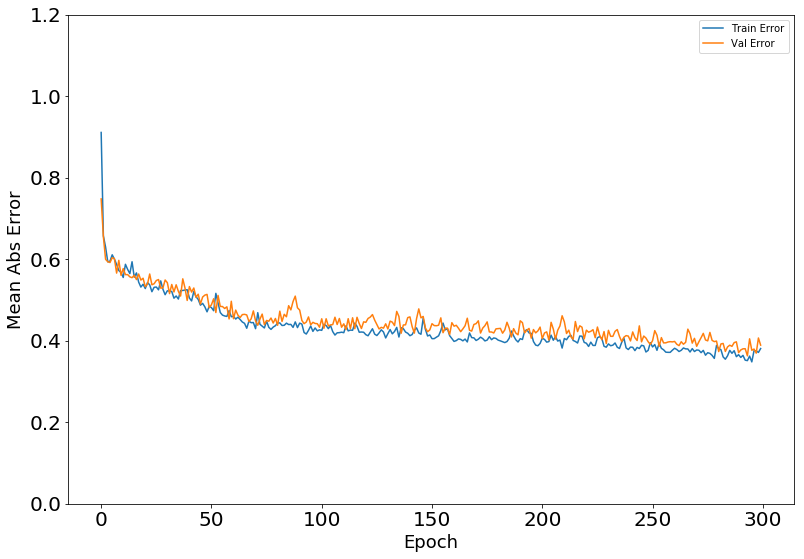

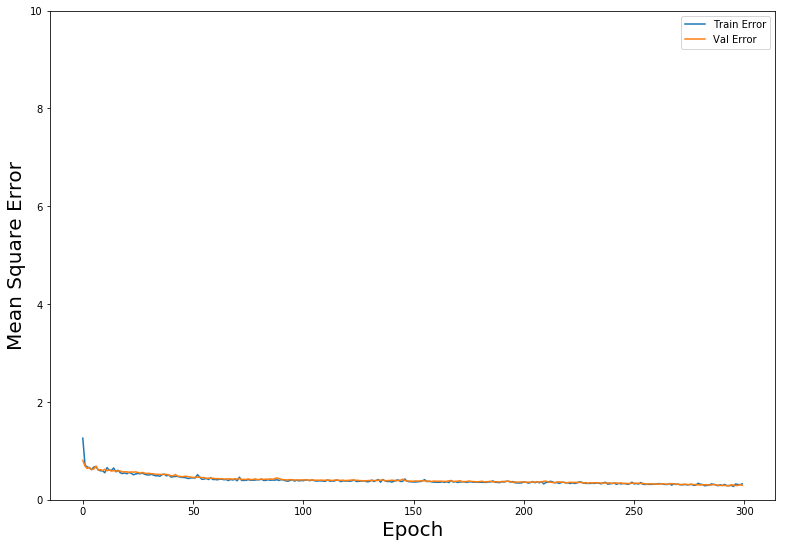

In [24]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize= 18)
  plt.ylabel('Mean Abs Error', fontsize= 18)
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.2])
  plt.tick_params(labelsize=20)
  plt.legend()
  

  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Mean Square Error', fontsize= 20)
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()
  plt.show()


plot_history(history)

**Save model**

(238, 4)
(238,)
(238,)
(238,)
(238,)


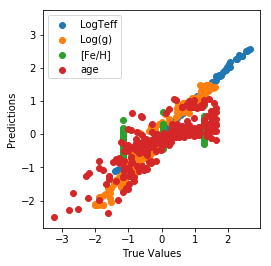

In [26]:
#test_predictions = model.predict([x_RVStrain, x_BPtrain, x_RPtrain])
test_predictions = model.predict([ x_BPtrain])
print(np.shape(test_predictions))
print(np.shape(y_train_stack[:,0]))
print(np.shape(y_train_stack[:,1]))
print(np.shape(y_train_stack[:,2]))
print(np.shape(y_train_stack[:,3]))
plt.scatter(normalize(y_train_stack[:,0]), test_predictions[:,0], label= 'LogTeff')
plt.scatter(normalize(y_train_stack[:,1]), test_predictions[:,1], label= 'Log(g)')
plt.scatter(normalize(y_train_stack[:,2]), test_predictions[:,2], label= '[Fe/H]')
plt.scatter(normalize(y_train_stack[:,3]), test_predictions[:,3], label= 'age')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.legend()
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([1.4, 1.4], [1.4, 1.4])
#print('test predictions=', test_predictions)

(238,)
(238,)
(238,)
(238,)
shape of test_predictions: (238, 4)
print 10 elements of test_predictions: [[-1.0416946   1.4738736   0.24281198  0.8228802 ]
 [-0.7059042  -1.4530212  -0.03092255 -0.46421018]
 [-1.0894682   1.4284626   0.29999468  0.7882422 ]
 [-0.6012386  -1.0592023  -0.06140889 -0.39080983]
 [ 2.2615044   0.9383116  -0.10126588 -1.7508812 ]
 [ 0.6447089   1.0224683   0.05835199 -0.13555342]
 [-0.88149375  1.2089902   0.18147801  1.0153202 ]
 [ 1.6051681   0.98894024  0.05095794 -1.139332  ]
 [-0.81736773 -1.0791006  -0.12057162  0.4862961 ]
 [-0.42035967 -0.2541614  -0.26271483  0.19406539]]


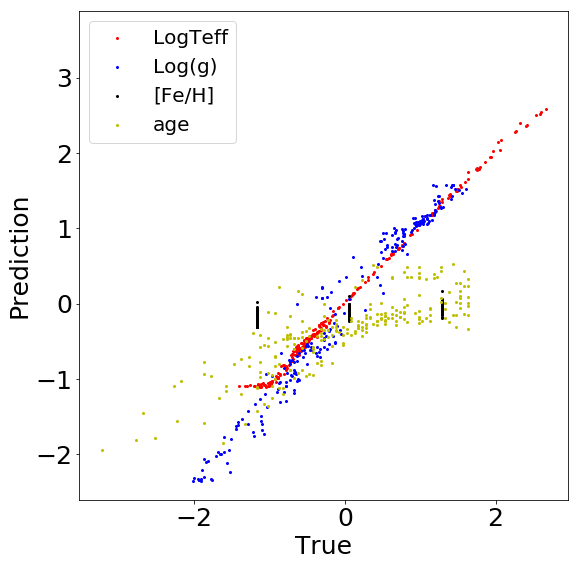

In [28]:
#Unnormalizing the labels (teff)

print(np.shape(y_train_stack[:,0]))
print(np.shape(y_train_stack[:,1]))
print(np.shape(y_train_stack[:,2]))
print(np.shape(y_train_stack[:,3]))



def denormalize (labels):
    mean_labels=np.mean(labels)
    std_labels=np.std(labels)
    return (((labels)*(std_labels)) + mean_labels)

plt.figure(figsize=(13,9))
#test_predictions = model.predict([x_RVStrain, x_BPtrain, x_RPtrain])
test_predictions = model.predict([x_BPtrain])
print('shape of test_predictions:',np.shape(test_predictions))
print('print 10 elements of test_predictions:', test_predictions[0:10])
plt.scatter(denormalize(y_train_stack[:,0]), denormalize(test_predictions[:,0]), s= 4.0, c= 'r', label='LogTeff' )
plt.scatter(denormalize(y_train_stack[:,1]), denormalize(test_predictions[:,1]), s= 4.0, c= 'b', label='Log(g)' )
plt.scatter(denormalize(y_train_stack[:,2]), denormalize(test_predictions[:,2]), s= 4.0, c= 'k', label='[Fe/H]' )
plt.scatter(denormalize(y_train_stack[:,3]), denormalize(test_predictions[:,3]), s= 4.0, c= 'y', label='age' )
plt.xlabel(r"True", fontsize=25)
plt.ylabel(r"Prediction", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize= 25) 
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-2, 3], [-2, 3], color='green')
plt.legend(fontsize=20)




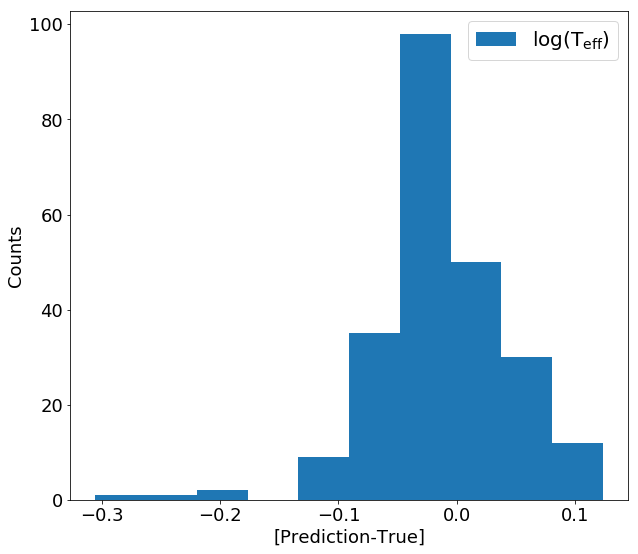

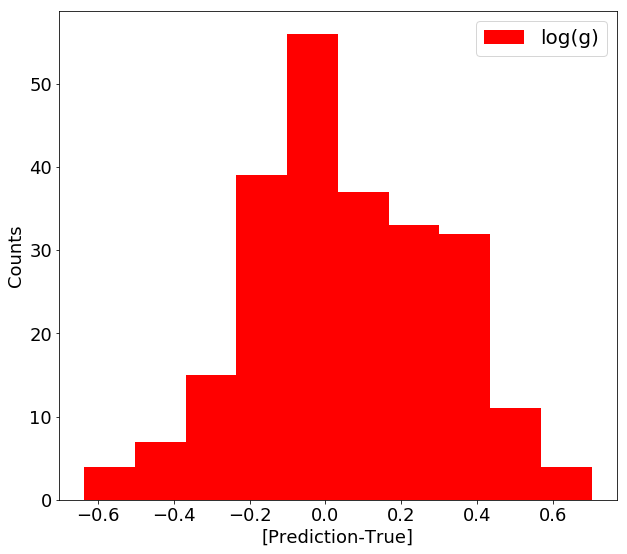

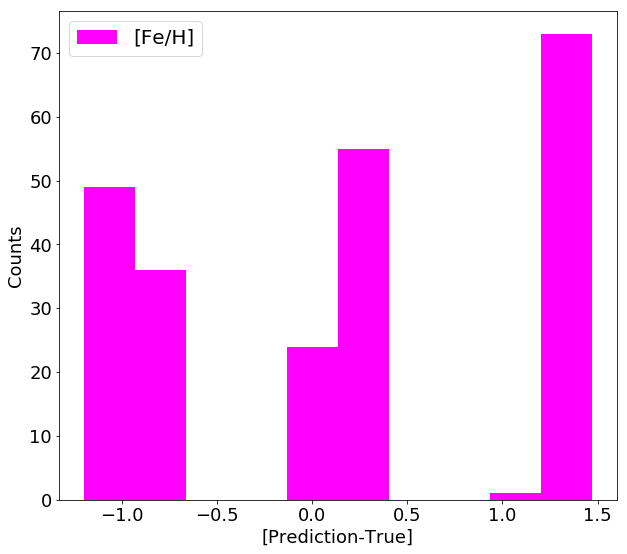

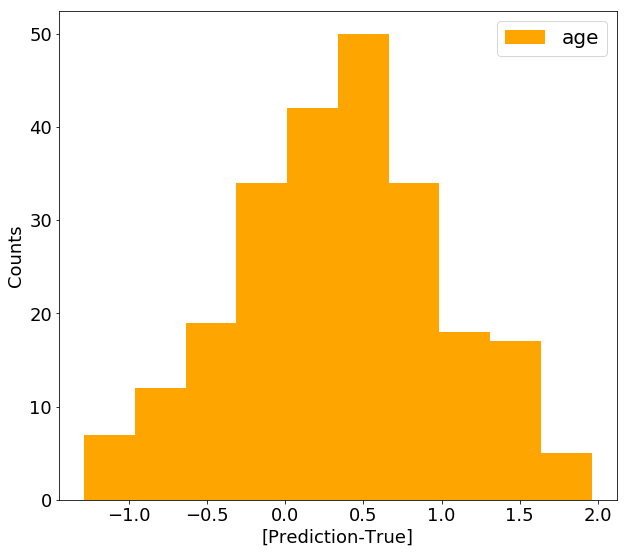

In [29]:
#Making the histogram of denormalized training set 

plt.figure(figsize=(10,9))
data_teff=np.subtract(denormalize(y_train_stack[:,0]), denormalize(test_predictions[:,0])) 
data_logg=np.subtract(denormalize(y_train_stack[:,1]), denormalize(test_predictions[:,1])) 
data_feh=np.subtract(denormalize(y_train_stack[:,2]), denormalize(test_predictions[:,2])) 
data_age=np.subtract(denormalize(y_train_stack[:,3]), denormalize(test_predictions[:,3])) 

counts_teff, bins_teff = np.histogram(data_teff)
counts_logg, bins_logg = np.histogram(data_logg)
counts_feh, bins_feh = np.histogram(data_feh)
counts_age, bins_age = np.histogram(data_age)


#histogram for LogTeff
plt.hist(bins_teff[:-1], bins_teff, weights=counts_teff, label= r'$\rm log(\rm T_{\rm eff})$')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()

#histogram for Log(g)
plt.figure(figsize=(10,9))
plt.hist(bins_logg[:-1], bins_logg, weights=counts_logg, label= 'log(g)', color='red')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()

#histogram for [Fe/H]
plt.figure(figsize=(10,9))
plt.hist(bins_feh[:-1], bins_feh, weights=counts_feh, label= '[Fe/H]', color='magenta')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()

#histogram for age
plt.figure(figsize=(10,9))
plt.hist(bins_age[:-1], bins_age, weights=counts_age, label= 'age', color='orange')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()




#print('standard deviation', len(z))
#print(len(z[teff<5000]))
#print(len(z))


# Training Data Set

In [30]:
# getting deviation in Teff bins
nbin = 6
teffbin_edges=np.array([-1.5, -0.5, 0., 0.5, 1.0, 1.5, 2.0])

# pred vs. true
# unnormalised values
teff_pred = denormalize(test_predictions[:,0])
teff_true = denormalize(y_train_stack[:,0]) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))

####################################################################################################################
print('=================================================================================================')
# getting deviation in Teff bins
nbin = 6
loggbin_edges=np.array([-1.5, -0.5, 0., 0.5, 1.0, 1.5, 2.0])

# pred vs. true
# unnormalised values
logg_pred = denormalize(test_predictions[:,1])
logg_true = denormalize(y_train_stack[:,1]) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
logg_diff = logg_pred-logg_true

# compute mean and std in Teff bins
logg_diff_mean = np.zeros(nbin) 
logg_diff_std = np.zeros(nbin)
loggbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(logg_true<loggbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(logg_true>loggbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((logg_true>loggbin_edges[i-1]) & (logg_true<loggbin_edges[i]))

    loggbin_mean[i] = np.mean(logg_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    logg_diff_mean[i] = np.mean(logg_diff[indx]) #calculating the mean values of teff_diff from its index 
    logg_diff_std[i] = np.std(logg_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin logg_true=', loggbin_mean)
print('mean of logg_diff=', logg_diff_mean)
print('std of logg_diff=', logg_diff_std)
print('length of logg_diff=', len(logg_diff))




####################################################################################################################
print('=================================================================================================')
# getting deviation in feh bins
nbin = 6
fehbin_edges=np.array([-1.5, -0.5, 0., 0.5, 1.0, 1.5, 2.0])

# pred vs. true
# unnormalised values
feh_pred = denormalize(test_predictions[:,2])
feh_true = denormalize(y_train_stack[:,2]) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
feh_diff = feh_pred-feh_true

# compute mean and std in Teff bins
feh_diff_mean = np.zeros(nbin) 
feh_diff_std = np.zeros(nbin)
fehbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(feh_true<fehbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(feh_true>fehbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((feh_true>fehbin_edges[i-1]) & (feh_true<fehbin_edges[i]))

    fehbin_mean[i] = np.mean(feh_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    feh_diff_mean[i] = np.mean(feh_diff[indx]) #calculating the mean values of teff_diff from its index 
    feh_diff_std[i] = np.std(feh_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin feh_true=', fehbin_mean)
print('mean of feh_diff=', feh_diff_mean)
print('std of feh_diff=', feh_diff_std)
print('length of feh_diff=', len(feh_diff))

####################################################################################################################
print('=================================================================================================')
# getting deviation in age bins
nbin = 6
agebin_edges=np.array([-1.5, -0.5, 0., 0.5, 1.0, 1.5, 2.0])

# pred vs. true
# unnormalised values
age_pred = denormalize(test_predictions[:,3])
age_true = denormalize(y_train_stack[:,3]) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
age_diff = feh_pred-feh_true

# compute mean and std in Teff bins
age_diff_mean = np.zeros(nbin) 
age_diff_std = np.zeros(nbin)
agebin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(age_true<agebin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(age_true>agebin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((age_true>agebin_edges[i-1]) & (age_true<agebin_edges[i]))

    agebin_mean[i] = np.mean(age_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    age_diff_mean[i] = np.mean(age_diff[indx]) #calculating the mean values of teff_diff from its index 
    age_diff_std[i] = np.std(age_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin age_true=', agebin_mean)
print('mean of age_diff=', age_diff_mean)
print('std of age_diff=', age_diff_std)
print('length of age_diff=', len(age_diff))




mean of bin teff_true= [        nan -0.80832274 -0.33111545  0.20147285  0.70656128  1.68452011]
mean of teff_diff= [       nan 0.00253275 0.00765385 0.02804917 0.03207312 0.03387706]
std of teff_diff= [       nan 0.07395599 0.03196145 0.01078126 0.00801226 0.04527267]
length of teff_diff= 238
mean of bin logg_true= [-1.77411445 -0.86948764 -0.26638131  0.30083811  0.76643867  1.20073936]
mean of logg_diff= [-0.37383084 -0.21700076 -0.07451259  0.14044687  0.13670825  0.07416581]
std of logg_diff= [0.12187662 0.20628195 0.2762457  0.24612772 0.13022147 0.09202489]
length of logg_diff= 238
mean of bin feh_true= [        nan -1.168784           nan  0.05663711         nan  1.28205822]
mean of feh_diff= [        nan  0.97483591         nan -0.17304049         nan -1.33998728]
std of feh_diff= [       nan 0.0862914         nan 0.06255613        nan 0.05773784]
length of feh_diff= 238
mean of bin age_true= [-2.11514138 -0.88857834 -0.25037682  0.26817405  0.75810692  1.39530448]
mean of age

/Users/aishasultan/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aishasultan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aishasultan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/aishasultan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/aishasultan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


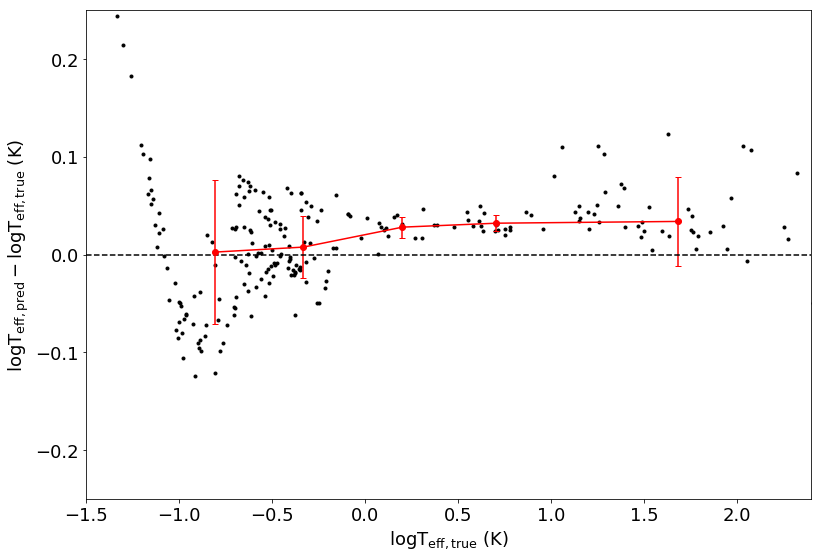

In [31]:
# plot of logteff
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean,teff_diff_mean, yerr=teff_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-1.5,2.4])
ylim=np.array([-0.25,0.25])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm logT_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$\rm logT_{\rm eff,pred}-\rm logT_{\rm eff,true}$ (K)", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')





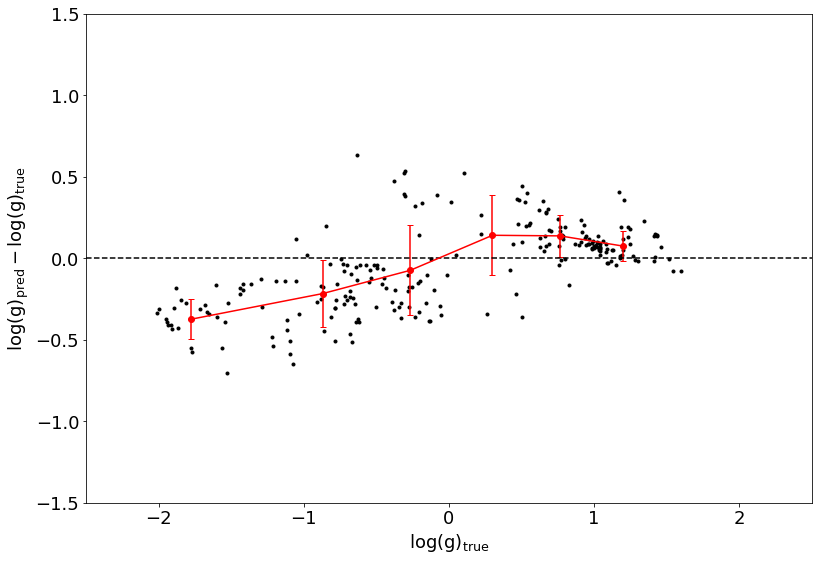

In [32]:
#Plot log 
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(logg_true, logg_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(loggbin_mean,logg_diff_mean, yerr=logg_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
#plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-2.5,2.5])
ylim=np.array([-1.5,1.5])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])


# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=18)



# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')




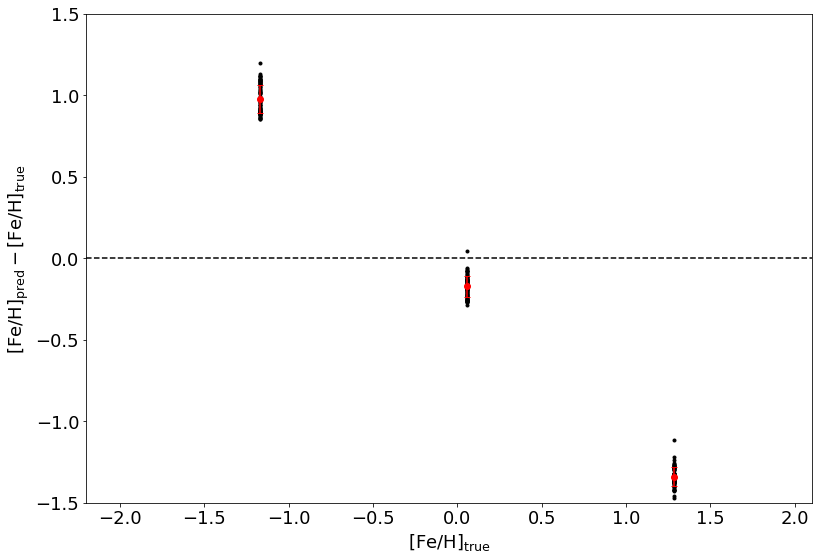

In [33]:
# plot of feh
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(feh_true, feh_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(fehbin_mean, feh_diff_mean, yerr=feh_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 



# set x, y lim plot range
xlim=np.array([-2.2, 2.1])
ylim=np.array([-1.5, 1.5])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm [Fe/H]_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm [Fe/H]_{\rm pred}-\rm [Fe/H]_{\rm true}$ ", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')




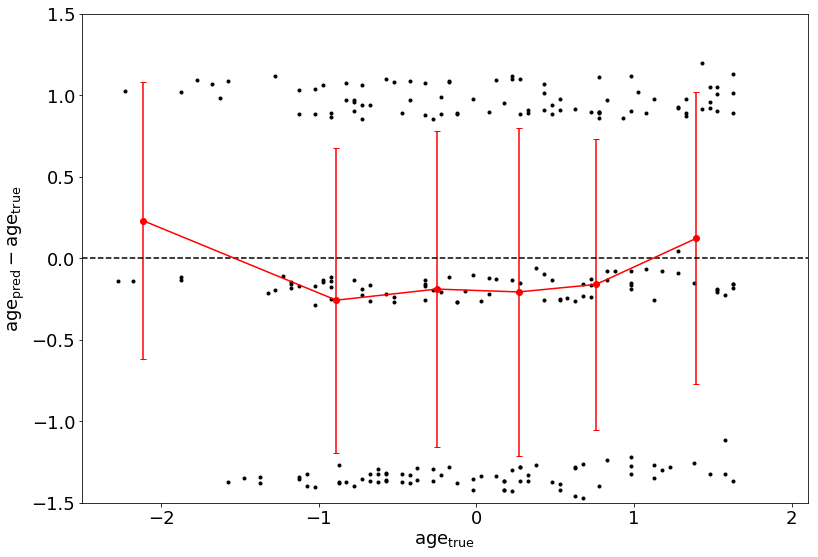

In [34]:
# plot of age
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(age_true, age_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(agebin_mean, age_diff_mean, yerr=age_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 



# set x, y lim plot range
xlim=np.array([-2.5, 2.1])
ylim=np.array([-1.5,1.5])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm age_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm age_{\rm pred}-\rm age_{\rm true}$ ", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

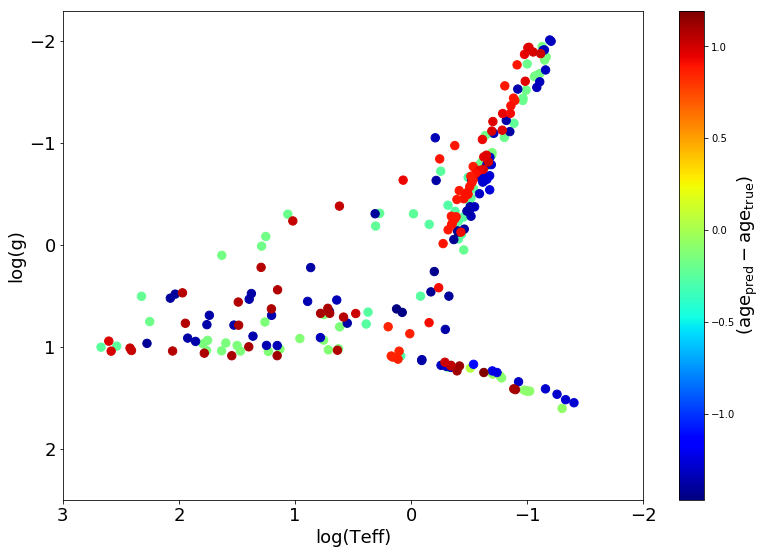

In [35]:

plt.figure(figsize=(13,9))
marker_size = 70
plt.scatter(teff_true, logg_true, s= marker_size, c= age_diff, cmap ='jet' )
plt.tick_params(labelsize=18)
plt.xlabel('log(Teff)', fontsize=18)
plt.ylabel('log(g)', fontsize=18)
plt.axis([3.0, -2.0, 2.5, -2.3])
cbar= plt.colorbar()
cbar.set_label(r"($\rm age_{\rm pred}-\rm age_{\rm true})$" , labelpad=+1, fontsize=18)
plt.show()




# Cross Validation Set

(62, 4)
len of y_cv_stack= 62


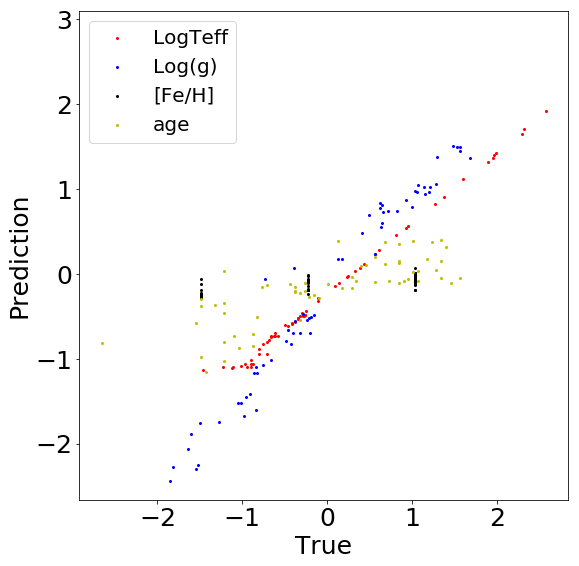

In [36]:
#Test set (x_cv)

plt.figure(figsize=(13,9))
#cv_predictions = model.predict([x_RVScv, x_BPcv, x_RPcv]).flatten()
cv_predictions = model.predict([x_BPcv])
print(np.shape(cv_predictions))

plt.scatter(denormalize(y_cv_stack[:,0]), denormalize(cv_predictions[:,0]), s= 4.0, c= 'r', label='LogTeff')
plt.scatter(denormalize(y_cv_stack[:,1]), denormalize(cv_predictions[:,1]), s= 4.0, c= 'b', label='Log(g)')
plt.scatter(denormalize(y_cv_stack[:,2]), denormalize(cv_predictions[:,2]), s= 4.0, c= 'k', label='[Fe/H]' )
plt.scatter(denormalize(y_cv_stack[:,3]), denormalize(cv_predictions[:,3]), s= 4.0, c= 'y', label='age' )

plt.xlabel(r"True", fontsize=25)
plt.ylabel(r"Prediction", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize= 25) 
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-2, 3], [-2, 3], color='green')
plt.legend(fontsize=20)


print('len of y_cv_stack=', len(y_cv_stack))



In [37]:
# getting deviation in Teff bins
nbin = 6
teffbin_edges=np.array([-1.5, -0.5, 0., 0.5, 1.0, 1.5, 2.0])

# pred vs. true
# unnormalised values
teff_pred = denormalize(cv_predictions[:,0])
teff_true = denormalize(y_cv_stack[:,0]) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))

####################################################################################################################
print('=================================================================================================')
# getting deviation in Teff bins
nbin = 6
loggbin_edges=np.array([-1.5, -0.5, 0., 0.5, 1.0, 1.5, 2.0])

# pred vs. true
# unnormalised values
logg_pred = denormalize(cv_predictions[:,1])
logg_true = denormalize(y_cv_stack[:,1]) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
logg_diff = logg_pred-logg_true

# compute mean and std in Teff bins
logg_diff_mean = np.zeros(nbin) 
logg_diff_std = np.zeros(nbin)
loggbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(logg_true<loggbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(logg_true>loggbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((logg_true>loggbin_edges[i-1]) & (logg_true<loggbin_edges[i]))

    loggbin_mean[i] = np.mean(logg_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    logg_diff_mean[i] = np.mean(logg_diff[indx]) #calculating the mean values of teff_diff from its index 
    logg_diff_std[i] = np.std(logg_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin logg_true=', loggbin_mean)
print('mean of logg_diff=', logg_diff_mean)
print('std of logg_diff=', logg_diff_std)
print('length of logg_diff=', len(logg_diff))




####################################################################################################################
print('=================================================================================================')
# getting deviation in feh bins
nbin = 6
fehbin_edges=np.array([-1.5, -0.5, 0., 0.5, 1.0, 1.5, 2.0])

# pred vs. true
# unnormalised values
feh_pred = denormalize(cv_predictions[:,2])
feh_true = denormalize(y_cv_stack[:,2]) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
feh_diff = feh_pred-feh_true

# compute mean and std in Teff bins
feh_diff_mean = np.zeros(nbin) 
feh_diff_std = np.zeros(nbin)
fehbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(feh_true<fehbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(feh_true>fehbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((feh_true>fehbin_edges[i-1]) & (feh_true<fehbin_edges[i]))

    fehbin_mean[i] = np.mean(feh_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    feh_diff_mean[i] = np.mean(feh_diff[indx]) #calculating the mean values of teff_diff from its index 
    feh_diff_std[i] = np.std(feh_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin feh_true=', fehbin_mean)
print('mean of feh_diff=', feh_diff_mean)
print('std of feh_diff=', feh_diff_std)
print('length of feh_diff=', len(feh_diff))

####################################################################################################################
print('=================================================================================================')
# getting deviation in age bins
nbin = 3
agebin_edges=np.array([-2.0, 0, 2.0])

# pred vs. true
# unnormalised values
age_pred = denormalize(cv_predictions[:,3])
age_true = denormalize(y_cv_stack[:,3]) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
age_diff = feh_pred-feh_true

# compute mean and std in Teff bins
age_diff_mean = np.zeros(nbin) 
age_diff_std = np.zeros(nbin)
agebin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(age_true<agebin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(age_true>agebin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((age_true>agebin_edges[i-1]) & (age_true<agebin_edges[i]))

    agebin_mean[i] = np.mean(age_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    age_diff_mean[i] = np.mean(age_diff[indx]) #calculating the mean values of teff_diff from its index 
    age_diff_std[i] = np.std(age_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin age_true=', agebin_mean)
print('mean of age_diff=', age_diff_mean)
print('std of age_diff=', age_diff_std)
print('length of age_diff=', len(age_diff))



        

mean of bin teff_true= [        nan -0.83809808 -0.30366167  0.26699034  0.77257902  1.92411131]
mean of teff_diff= [        nan -0.07921052 -0.18671877 -0.27581492 -0.35655427 -0.55986536]
std of teff_diff= [       nan 0.11172751 0.02014334 0.03308653 0.02900055 0.0716326 ]
length of teff_diff= 62
mean of bin logg_true= [-1.6405025  -0.90009836 -0.31901144  0.30267495  0.71367257  1.30506048]
mean of logg_diff= [-0.49691417 -0.36699913 -0.24566076  0.07937633 -0.01320944 -0.11226903]
std of logg_diff= [0.18480877 0.33314376 0.22261962 0.07536268 0.1580073  0.1077102 ]
length of logg_diff= 62
mean of bin feh_true= [        nan -1.48362952 -0.22356061         nan         nan  1.03650829]
mean of feh_diff= [        nan  1.25487245  0.11304073         nan         nan -1.09215471]
std of feh_diff= [       nan 0.05911326 0.05977473        nan        nan 0.06046372]
length of feh_diff= 62
mean of bin age_true= [-2.65288766 -0.83442451  0.83909995]
mean of age_diff= [ 0.15009143  0.05745825 -

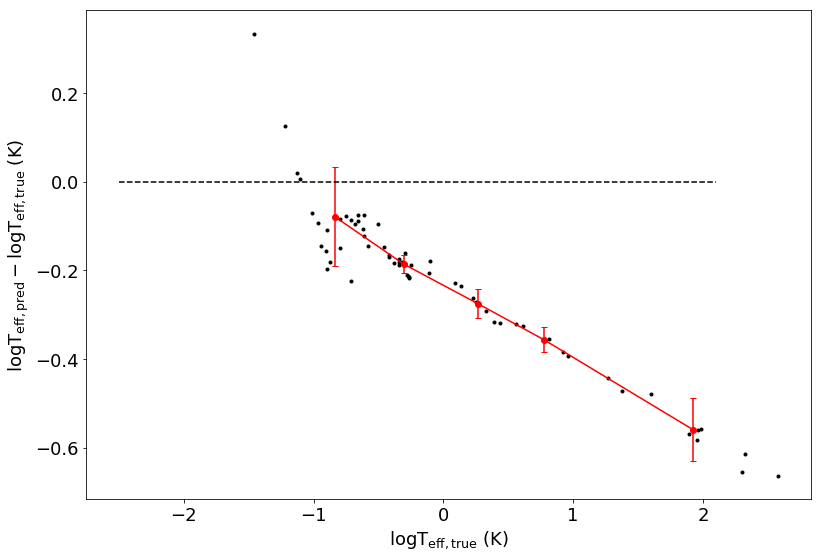

In [38]:

# plot of logteff
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean,teff_diff_mean, yerr=teff_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
#xlim=np.array([-1.5,2.4])
#ylim=np.array([-0.25,0.25])
#plt.xlim(xlim[0],xlim[1]) #plotting the xlim
#plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm logT_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$\rm logT_{\rm eff,pred}-\rm logT_{\rm eff,true}$ (K)", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')





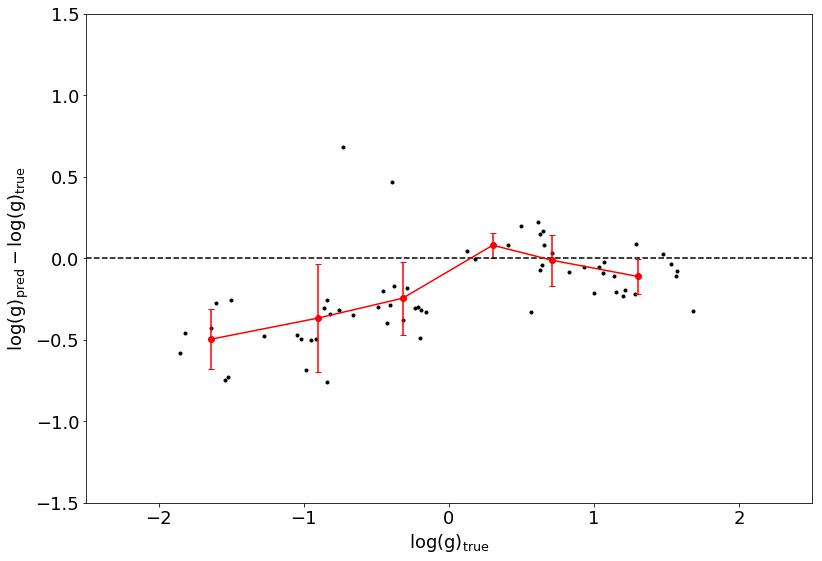

In [39]:
#Plot log 
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(logg_true, logg_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(loggbin_mean,logg_diff_mean, yerr=logg_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
#plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-2.5,2.5])
ylim=np.array([-1.5,1.5])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])


# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=18)



# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')



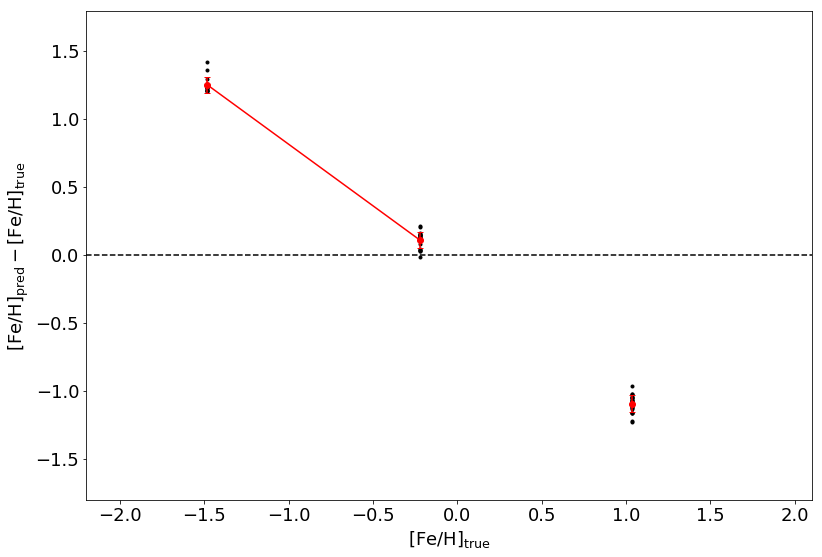

In [40]:
# plot of feh
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(feh_true, feh_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(fehbin_mean, feh_diff_mean, yerr=feh_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 



# set x, y lim plot range
xlim=np.array([-2.2, 2.1])
ylim=np.array([-1.8, 1.8])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm [Fe/H]_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm [Fe/H]_{\rm pred}-\rm [Fe/H]_{\rm true}$ ", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')


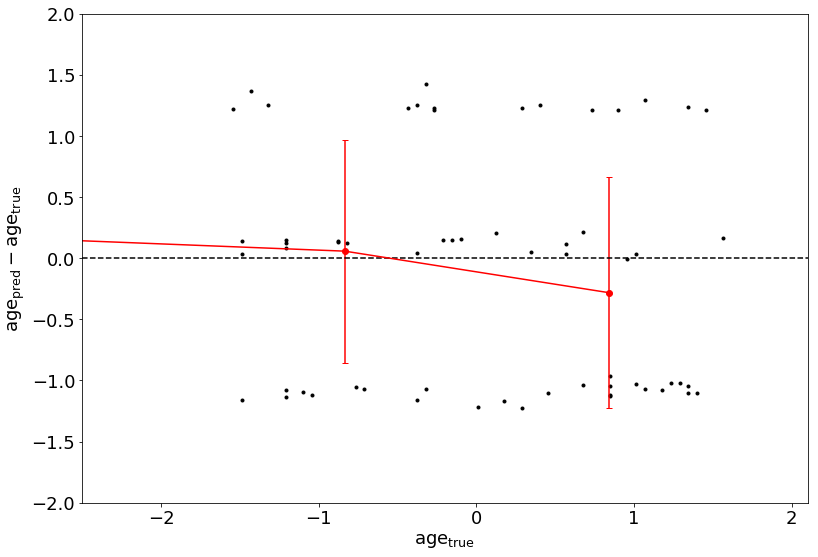

In [41]:
# plot of age
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(age_true, age_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(agebin_mean, age_diff_mean, yerr=age_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 



# set x, y lim plot range
xlim=np.array([-2.5, 2.1])
ylim=np.array([-2.0, 2.0])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm age_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm age_{\rm pred}-\rm age_{\rm true}$ ", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

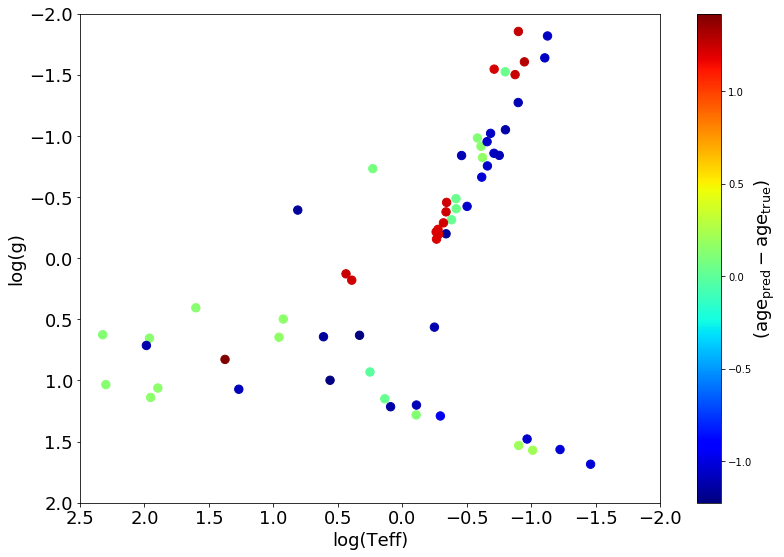

In [42]:

plt.figure(figsize=(13,9))
marker_size = 70
plt.scatter(teff_true, logg_true, s= marker_size, c= age_diff, cmap ='jet' )
plt.tick_params(labelsize=18)
plt.xlabel('log(Teff)', fontsize=18)
plt.ylabel('log(g)', fontsize=18)
plt.axis([2.5, -2.0, 2.0, -2.0])
cbar= plt.colorbar()
cbar.set_label(r"($\rm age_{\rm pred}-\rm age_{\rm true})$" , labelpad=+1, fontsize=18)
plt.show()


